In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize, normalize

from utils import DataLoader, DataProcesser, label_plot, TimeKeeper

%load_ext autoreload
%autoreload 2

In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Data

In [3]:
# train
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
# data.df = pd.read_csv('data/mid_res/20210525_data_df.csv')
# dp = DataProcesser.DataProcesser(data)
# dp.process_data_more()

In [4]:
# validate
# with open('data/mid_res/val_ft.pickle', 'rb') as file:
#     val = pickle.load(file)
# dp_val = DataProcesser.DataProcesser(val)
# dp_val.process_data_more()
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)

In [6]:
# data.df.to_csv('data/mid_res/20210526_data_df.csv', header = True, index = False)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
# val.df.to_csv('data/mid_res/20210526_val_df.csv', header = True, index = False)
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [7]:
# list(data.df)

In [8]:
def data_have_source(data):
    data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
    data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
    data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
    data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

# data_have_source(data)
# data_have_source(val)

In [74]:
# data.df = data.df.drop(['have_loc', 'have_gps', 'have_wifi', 'have_cells'], axis = 1)
# val.df = val.df.drop(['have_loc', 'have_gps', 'have_wifi', 'have_cells'], axis = 1)

In [9]:
col_drop_x = ['time', 'label']
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed',

#  'wifi_rssi_min',
#  'wifi_rssi_std',
#  'wifi_rssi_mode',

#  'cells_asuLevel_min',
#  'cells_dbm_min',
#  'cells_level_min',
#  'cells_asuLevel_max',
#  'cells_dbm_max',
#  'cells_level_max',
#  'cells_asuLevel_std',
#  'cells_dbm_std'
 ]

In [10]:
list(data.df.drop(col_drop, axis = 1))

['time',
 'label',
 'accuracy',
 'num_gps',
 'num_wifi',
 'num_cells',
 'acc',
 'wifi_rssi_mode',
 'wifi_rssi_mean',
 'wifi_rssi_min',
 'wifi_rssi_max',
 'wifi_rssi_std',
 'wifi_freq_5ratio',
 'cells_isRegistered_mean',
 'cells_asuLevel_mean',
 'cells_dbm_mean',
 'cells_level_mean',
 'cells_asuLevel_min',
 'cells_dbm_min',
 'cells_level_min',
 'cells_asuLevel_max',
 'cells_dbm_max',
 'cells_level_max',
 'cells_asuLevel_std',
 'cells_dbm_std',
 'gps_snr_mean',
 'gps_snr_min',
 'gps_snr_max',
 'gps_snr_std',
 'speed_log',
 'acc_wd_std',
 'speed_wd_std',
 'speed_wd_max_log',
 'acc_wd_std_log']

# Model

In [11]:
def evaluate(y_true, y_pred):
    conf = confusion_matrix(y_true , y_pred)
    print(conf)
    sns.heatmap(conf)
    print(classification_report(y_true, y_pred, target_names = list(label_dic.values())))

In [12]:
test_ratio = 0.2
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df['label'], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df['label']

## LightGBM

In [20]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_test, label = y_test - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':8,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5001
[LightGBM] [Info] Number of data points in the train set: 784421, number of used features: 32
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.080591
[LightGBM] [Info] Start training from score -2.076322
[LightGBM] [Info] Start training from score -3.145195
[LightGBM] [Info] Start training from score -2.122439
[LightGBM] [Info] Start training from

In [21]:
pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[[16820  7935    12    84     0   479   277  4229]
 [ 4483 16976   101   884   301  2206   758   440]
 [    2  1015   335  1410     6     2     2     2]
 [  289   934  1664  7686    19     4    16  1419]
 [  326   310     4  1091 10944  4204  2816   778]
 [  528    54     7    88    92  5372  1553  1484]
 [ 4982    46     0   113  3968  1068 11012   619]
 [ 1236   510     2    12  2069   215  2579 15086]]
              precision    recall  f1-score   support

       Still       0.59      0.56      0.58     29836
     Walking       0.61      0.65      0.63     26149
         Run       0.16      0.12      0.14      2774
        Bike       0.68      0.64      0.66     12031
         Car       0.63      0.53      0.58     20473
         Bus       0.40      0.59      0.47      9178
       Train       0.58      0.50      0.54     21808
      Subway       0.63      0.69      0.66     21709

    accuracy                           0.59    143958
   macro avg       0.53      0.54      0.53    14

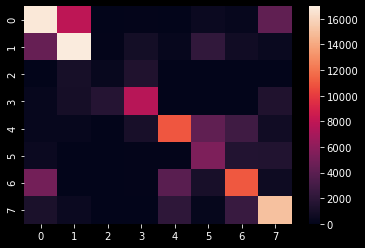

In [22]:
evaluate(y_val, pred_lgb)

### Grid Research

In [14]:
from lightgbm import LGBMClassifier

parameters = {
              'max_depth': [5, 15, 20],
              'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9],
              'lambda_l1': [0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0.2, 0.4, 1, 5, 10, 20]
}
gbm = LGBMClassifier(max_depth=3,
                    learning_rate=0.1,
                    n_estimators=20, # 使用多少个弱分类器
                    objective='multiclass',
                    num_class=8,
                    booster='gbtree',
                    min_child_weight=2,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    # reg_alpha=0,
                    # reg_lambda=1,
                    seed=0 # 随机数种子
                )

In [15]:
# 跑一下午都没跑出来
# from sklearn.model_selection import GridSearchCV

# gsearch = GridSearchCV(gbm, param_grid = parameters, scoring = 'accuracy', cv = 3)
# gsearch.fit(X_train, y_train)

sample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l1 is set=0.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l1 is set=0.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning

TypeError: object of type 'NoneType' has no len()

In [ ]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Evaluate

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

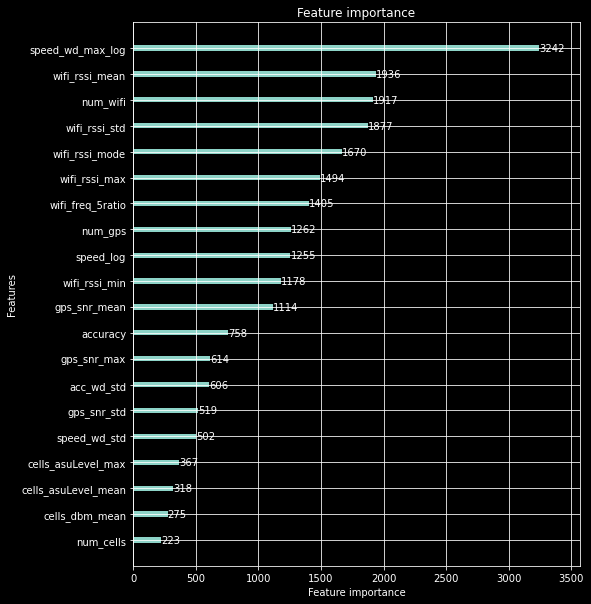

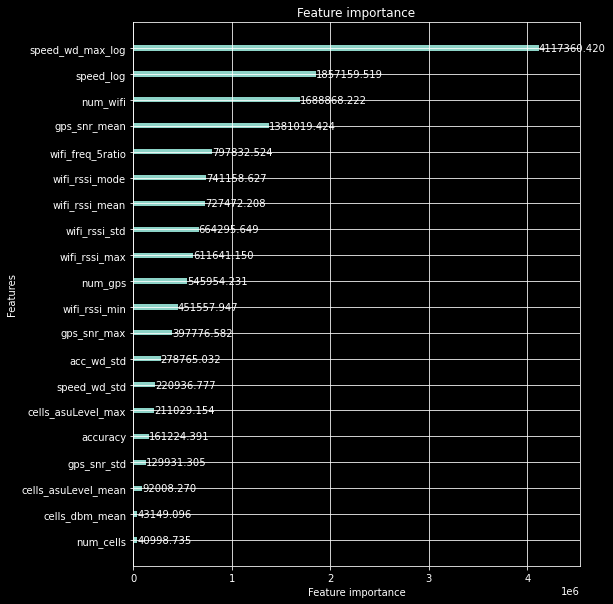

In [40]:
from lightgbm import plot_importance

plot_importance(model_lgb, max_num_features = 20, figsize = (8, 10), importance_type = 'split')
plot_importance(model_lgb, max_num_features = 20, figsize = (8, 10), importance_type = 'gain')

In [26]:
# from lightgbm import plot_importance

# plot_importance(model_lgb, 10)
# # plt.show()

## NB

In [96]:
model_nb = GaussianNB().fit(X_train, y_train)
pred_nb = model_nb.predict(X_val)

[[23467  2533    17    36    16   319   194  3254]
 [ 4404 11589  5969   196    43  3054   172   722]
 [   26   657  1876    88     1   120     1     5]
 [  461  1498  5350  2873     0    10    79  1760]
 [ 1432   285   191  5083  5528  6145  1121   688]
 [ 3709   237    43   636   188  4047   117   201]
 [12932   211     0   606  2216  1374  3873   596]
 [11508    62     0   128   247  1650    17  8097]]
              precision    recall  f1-score   support

       Still       0.41      0.79      0.53     29836
     Walking       0.68      0.44      0.54     26149
         Run       0.14      0.68      0.23      2774
        Bike       0.30      0.24      0.27     12031
         Car       0.67      0.27      0.39     20473
         Bus       0.24      0.44      0.31      9178
       Train       0.69      0.18      0.28     21808
      Subway       0.53      0.37      0.44     21709

    accuracy                           0.43    143958
   macro avg       0.46      0.43      0.37    14

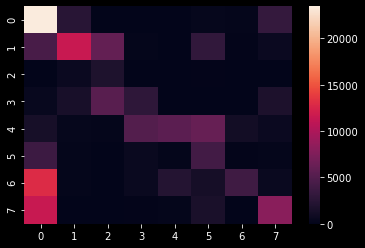

In [107]:
evaluate(y_val, pred_nb)

## LR

In [111]:
model_lr = LogisticRegression(random_state = 99).fit(X_train, y_train)
pred_lr = model_lr.predict(X_val)

[[14999  5518    24   869   387  3871  3168  1000]
 [ 3559  9374   122  2109   421  8707   991   866]
 [   54   475     2   706   288   961    28   260]
 [  407  2785   962  4880     0    14  1584  1399]
 [  767   614    25  2438  9331  2011  4195  1092]
 [ 2271   520    43   498   140  4272  1036   398]
 [ 6784  1108   410   557  5006   663  6344   936]
 [ 1446   435    12   383  1525   586  8969  8353]]
              precision    recall  f1-score   support

       Still       0.50      0.50      0.50     29836
     Walking       0.45      0.36      0.40     26149
         Run       0.00      0.00      0.00      2774
        Bike       0.39      0.41      0.40     12031
         Car       0.55      0.46      0.50     20473
         Bus       0.20      0.47      0.28      9178
       Train       0.24      0.29      0.26     21808
      Subway       0.58      0.38      0.46     21709

    accuracy                           0.40    143958
   macro avg       0.36      0.36      0.35    14

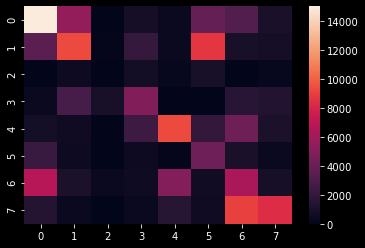

In [112]:
evaluate(y_val, pred_lr)

## Stacking

In [143]:
X_train2 = X_train.copy()
X_train2['prepred'] = model_lgb.predict(X_train).argmax(axis = 1) + 1

X_val2 = X_val.copy()
X_val2['prepred'] = model_lgb.predict(X_val).argmax(axis = 1) + 1

In [168]:
sclf = StackingClassifier(classifiers=[model_nb, model_lr], 
                          meta_classifier = LogisticRegression())

In [169]:
sclf.fit(X_train, y_train)

StackingClassifier(classifiers=[GaussianNB(),
                                LogisticRegression(random_state=99)],
                   meta_classifier=LogisticRegression())

In [170]:
pred_sclf = sclf.predict(X_val)

[[23384  1393     0     0   438    10  1230  3381]
 [ 5166  9141     0     0  3129   936  6809   968]
 [  206   511     0     0   155   479  1174   249]
 [  763  3330     0     0  2468  2473   474  2523]
 [ 1401   186     0     0 10517    72  3873  4424]
 [ 3419   132     0     0  3912     1   651  1063]
 [ 9083   243     0     0  4887     0  4209  3386]
 [ 3015    86     0     0  1254     0  8548  8806]]
              precision    recall  f1-score   support

       Still       0.50      0.78      0.61     29836
     Walking       0.61      0.35      0.44     26149
         Run       0.00      0.00      0.00      2774
        Bike       0.00      0.00      0.00     12031
         Car       0.39      0.51      0.45     20473
         Bus       0.00      0.00      0.00      9178
       Train       0.16      0.19      0.17     21808
      Subway       0.36      0.41      0.38     21709

    accuracy                           0.39    143958
   macro avg       0.25      0.28      0.26    14

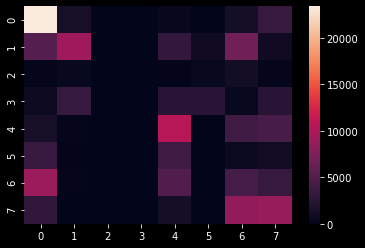

In [171]:
evaluate(y_val, pred_sclf)

## Voting

In [172]:
vclf = VotingClassifier(estimators=[model_nb, model_lr], voting='hard')

In [167]:
vclf.fit(X_train, y_train)

TypeError: 'GaussianNB' object is not iterable

In [163]:
cross_val_score(vclf, X_train, y_train, cv=5, scoring='accuracy')

array([nan, nan, nan, nan, nan])

In [164]:
cross_val_score(model_nb, X_train, y_train, cv=5, scoring='accuracy')

array([0.43567581, 0.43302695, 0.43419979, 0.4330142 , 0.43335203])